# Install and imports of Libraries

We need to update and download libraries to make sure everything is at the latest.

In [1]:
%%capture
!pip install -U lightning twitch-dl polars mlflow dagshub mlflow "pydantic<2.0.0"
!apt install rclone

## Downloading and converting video

In [1]:
import ipywidgets
from IPython.display import display
import ingest
import r2
from pathlib import Path
import polars as pl

TWITCH_ID = ipywidgets.Text("1913327875", description="Twitch ID")

display(TWITCH_ID)

Text(value='1913327875', description='Twitch ID')

### Download, Converting and Saving
Run this cell

In [ ]:
print("Fixing video..")
ingest.download_twitch_stream(str(TWITCH_ID.value))
ingest.vid_to_frames(str(TWITCH_ID.value), use_cuda=False)
# tar_file = r2.compress(str(TWITCH_ID.value))
# r2.upload(tar_file)

Downloaded 27/2294 VODs 1% of ~9.1GB at 10.1MB/s ETA 15:09     

## Get data from drive/r2
Run cell below

In [2]:
from pathlib import Path
import polars as pl

if not Path("highlights.tsv").exists():
  r2.download("highlights.tsv")

df = pl.read_csv("highlights.tsv", separator="\t", try_parse_dates=True)

In [3]:
%%capture

for vid in df["vid_id"].unique():
  if not Path(f"{vid}").exists():
    r2.download_frames_and_unpack(f"{vid}.tar.lz4")

### Labeling...
Run this cell

In [4]:
from pathlib import Path
import polars as pl

fps = 3

highlights = df.select(
        "vid_id",
        frame=pl.int_ranges(
            pl.col("start").cast(pl.Duration).dt.seconds() * fps,
            pl.col("stop").cast(pl.Duration).dt.seconds() * fps,
        ),
        label=pl.lit(1)
    ).explode("frame")
highlights.head(1)

shape: (1, 3)
┌────────────┬───────┬───────┐
│ vid_id     ┆ frame ┆ label │
│ ---        ┆ ---   ┆ ---   │
│ i64        ┆ i64   ┆ i32   │
╞════════════╪═══════╪═══════╡
│ 1863051677 ┆ 2148  ┆ 1     │
└────────────┴───────┴───────┘

In [5]:
import numpy as np

dfs = []
for vid in df["vid_id"].unique():
  frames = len(list(Path(str(vid)).glob("*.jpg")))
  dfs.append(pl.DataFrame({
      "vid_id": [vid] * frames,
      "frame": np.arange(1, frames + 1)
      }))

labeled_df = pl.concat(dfs)
labeled_df = labeled_df.join(highlights, on=["vid_id", "frame"], how="left").fill_null(0)
labeled_df = labeled_df.with_columns(path=pl.concat_str([pl.col("vid_id").cast(pl.Utf8) + "/img", pl.col("frame").cast(pl.Utf8) + ".jpg"]))
labeled_df = labeled_df.sort("vid_id", "frame")
labeled_df.head(2)

shape: (2, 4)
┌────────────┬───────┬───────┬─────────────────────┐
│ vid_id     ┆ frame ┆ label ┆ path                │
│ ---        ┆ ---   ┆ ---   ┆ ---                 │
│ i64        ┆ i64   ┆ i32   ┆ str                 │
╞════════════╪═══════╪═══════╪═════════════════════╡
│ 1863051677 ┆ 1     ┆ 0     ┆ 1863051677/img1.jpg │
│ 1863051677 ┆ 2     ┆ 0     ┆ 1863051677/img2.jpg │
└────────────┴───────┴───────┴─────────────────────┘

## Training (Lightning)
We train a model

## Run Training

In [6]:
from data_utils.frame_datamodule import FrameDataModule
from data_utils.frame_dataset import FrameDataset
from data_utils.rebalancing import balance_labels
from models.rnn import RNNClassifier
from models.resnet import ResNetClassifier
from models.lightning_wrapper import LightningWrapper

In [7]:
labeled_df_rebalanced = balance_labels(labeled_df, fraction=0.8)

Previously 12.8% highlights, now 42.3%


In [ ]:
# import dagshub
from lightning.pytorch.loggers import MLFlowLogger
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
from mlflow.pytorch import mlflow
import lightning as L

#dagshub.init("lol_highlights", "Lundez", mlflow=True)
mlf_logger = MLFlowLogger(log_model=True)
mlflow.pytorch.autolog()

BATCH_SIZE = 32
# Define the duration of each chunk in seconds
chunk_duration_s = 30
chunk_duration_frames = 3 * chunk_duration_s
# hf_hub:timm/efficientnet_el.ra_in1k
name = "hf_hub:tf_efficientnet_b4.ns_jft_in1k"
model = timm.create_model(name, pretrained=True)

name = "mobilevitv2_175.cvnets_in22k_ft_in1k_384"
model = LightningWrapper(name, num_classes=2, learning_rate=1e-4)

ds = FrameDataset(labeled_df_rebalanced, model.get_transforms(is_training=True), frames_per_clip=1)
data = FrameDataModule(ds, BATCH_SIZE, chunk_duration_frames, pin_memory=True)

trainer = L.Trainer(max_epochs=20, logger=mlf_logger, callbacks=[ModelCheckpoint(monitor="val_loss"), EarlyStopping(monitor="val_loss")])

with mlflow.start_run():
  trainer.fit(model, datamodule=data)

In [8]:
trainer.save_checkpoint(f"{name.replace("hf_hub:", "ckpts/")}.ckpt")

In [11]:
wrapper = LightningWrapper.load_from_checkpoint(f"{name}.ckpt")

In [9]:
import torch
torch.save(model.model, "resnet_bad.pt")

In [2]:
import r2
r2.upload("ckpts/timm/tf_efficientnet_b3.aa_in1k.ckpt", "models")

## Testing

In [21]:
import ingest
ingest.vid_to_frames("1886367077")

Already converted 1886367077 to frames


In [12]:
import inference
import lightning as L
from torchvision import models
from models.lightning_wrapper import LightningWrapper
from models.resnet import ResNetClassifier
from pathlib import Path
import torch

df = inference.run_inference(Path(f"{name}.ckpt"), Path("1886367077"), aggregate_duration=10)
df

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/londogard/micromamba/envs/highlights/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

torch.Size([13140, 2])
% highlights predicted tensor(0.0594)


shape: (439, 6)
┌───────┬───────┬──────┬────────┬────────┬───────────┐
│ frame ┆ preds ┆ hour ┆ minute ┆ second ┆ timestamp │
│ ---   ┆ ---   ┆ ---  ┆ ---    ┆ ---    ┆ ---       │
│ i64   ┆ i64   ┆ i64  ┆ i64    ┆ i64    ┆ time      │
╞═══════╪═══════╪══════╪════════╪════════╪═══════════╡
│ 0     ┆ 0     ┆ 0    ┆ 0      ┆ 0      ┆ 00:00:00  │
│ 10    ┆ 0     ┆ 0    ┆ 0      ┆ 10     ┆ 00:00:10  │
│ 20    ┆ 0     ┆ 0    ┆ 0      ┆ 20     ┆ 00:00:20  │
│ 30    ┆ 0     ┆ 0    ┆ 0      ┆ 30     ┆ 00:00:30  │
│ …     ┆ …     ┆ …    ┆ …      ┆ …      ┆ …         │
│ 4350  ┆ 2     ┆ 1    ┆ 12     ┆ 30     ┆ 01:12:30  │
│ 4360  ┆ 0     ┆ 1    ┆ 12     ┆ 40     ┆ 01:12:40  │
│ 4370  ┆ 0     ┆ 1    ┆ 12     ┆ 50     ┆ 01:12:50  │
│ 4380  ┆ 0     ┆ 1    ┆ 13     ┆ 0      ┆ 01:13:00  │
└───────┴───────┴──────┴────────┴────────┴───────────┘

In [13]:
import plotly.express as px

px.line(df, x="timestamp", y="preds", line_shape="hv")

## Old Code (Fast.AI)
See code below!

In [ ]:
from fastai.vision.all import *

In [ ]:
from sklearn.model_selection import train_test_split


def chunk_splitter(total_size: int, chunk_size: int, split: int | float) -> np.array:
    _, val_idxs = train_test_split(np.arange(total_size // chunk_size), test_size=split, random_state=42) # ignoring final unsized chunk
    is_valid = np.zeros(total_size, dtype=np.int8)

    for index in val_idxs:
        index *= chunk_size
        is_valid[index:index+chunk_size] = 1

    return is_valid

In [ ]:
from torchvision.datasets import ImageFolder

# Define the duration of each chunk in seconds
chunk_duration_s = 10
chunk_duration_frames = 3 * chunk_duration_s

# Define the path to the video frames directory
frames_directory = 'labeled_data'

# Create the ImageFolder dataset
dataset = ImageFolder(root=frames_directory)
# Calculate the total number of chunks
split = chunk_splitter(len(dataset), chunk_size=chunk_duration_frames, split=.15)

In [ ]:
dblock = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                    get_items=get_image_files,
                    splitter=MaskSplitter(split.astype("bool")),
                    get_y=parent_label,
                    item_tfms=Resize(224))
dls = ImageDataLoaders.from_dblock(dblock, frames_directory, path=frames_directory)

In [ ]:
len(split)

65731

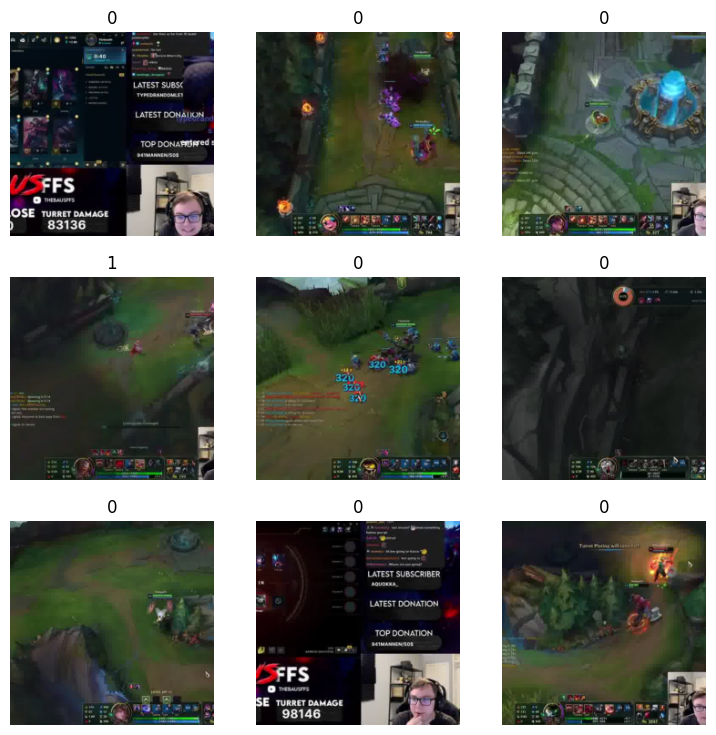

In [ ]:
dls.show_batch()

In [ ]:
learn = vision_learner(dls, resnet50, metrics=[error_rate, F1Score()])

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


SuggestedLRs(valley=0.001737800776027143)

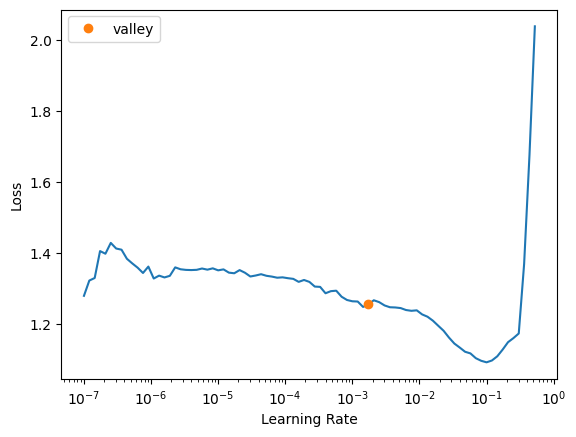

In [ ]:
learn.lr_find()

In [ ]:
learn.fine_tune(4, 1e-3)

In [ ]:
learn.export("/content/drive/MyDrive/datasets/fastai_resnet50.pth")

## Evaluation
And evaluating end-results